# 12-02 14:10~

## 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측(교재 5.2절)

**내장 데이터 활용 : boston 데이터 셋**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

In [2]:
# boston 데이타셋 로드
boston = load_boston() #warning 뜨는데 read.csv로 직접 파일을 읽어오라는 뜻인듯

C:\Users\a\anaconda3\envs\data_venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [4]:
# df 변환 후 내용 확인
bostonDF = pd.DataFrame(boston.data, columns= boston.feature_names) #딕셔너리로 온 것을 데이터프레임으로 만든다.
bostonDF['PRICE'] = boston.target

print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

# PRICE 예측해야 할 값

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- INDUS: 비상업 지역 넓이 비율
- CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- MEDV(PRICE): 본인 소유의 주택 가격(중앙값)(타겟값)

In [5]:
## null 값 없고 모두 float
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


집 값에 크게 영향을 미치는 중요한 요소
- 삶의 편리도를 생각하면 :  RM 거주할 수 있는 방 개수
- RAD: 고속도로 접근 용이도 : 미국은 차가 있어야 하니까
- ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD'] 선정

Seaborn의 regplot() 이용 
- 각 ax마다 칼럼과 PRICE의 관계 표현
- 2차원 평면에서 X축을 피처, Y축을 타겟값으로 설정하면
- 산점도와 함께 선형 회귀 직선 표시

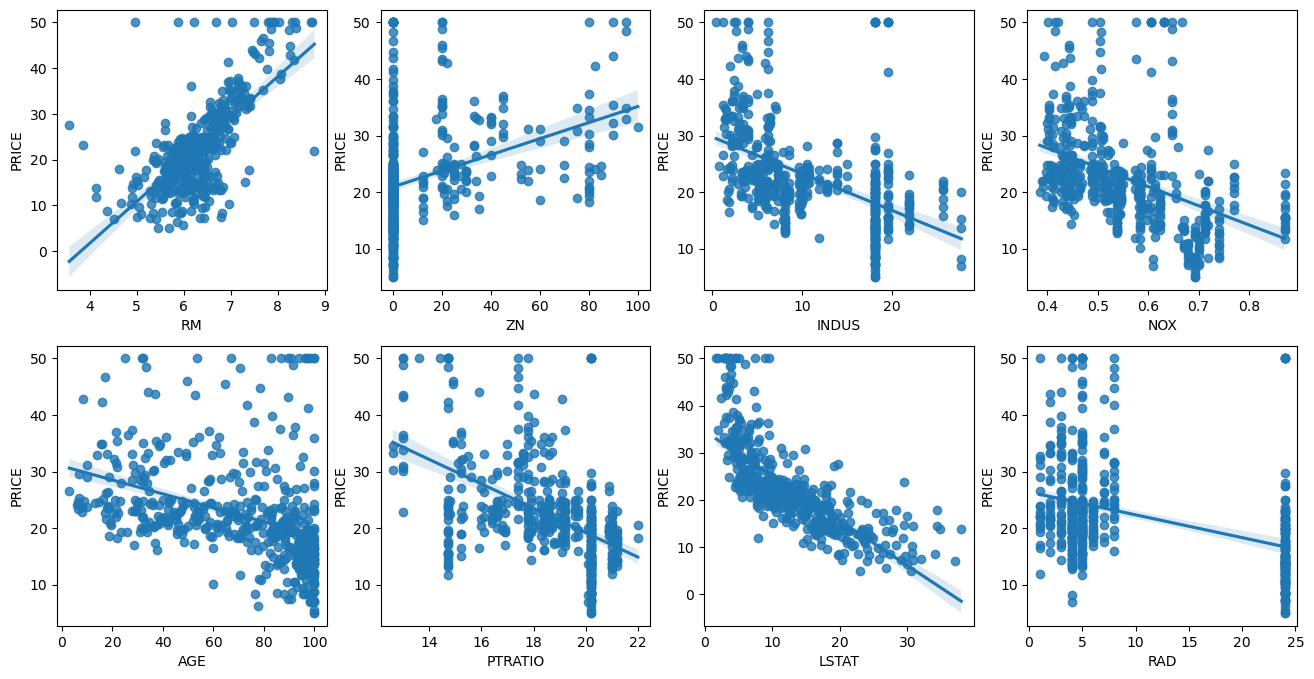

In [7]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']

# 각 요소에 대해 시각화
for i , feature in enumerate(lm_features): #RM이라는 피쳐가 0번째에 있다 이런 정보가 enumerate()에 의해서 나온다.
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col]) #RM이 가장 눈에 띄게 선형관계를 보인다.

LinearRegression 클래스를 이용해서 보스턴 주택 가격의 회귀 모델 만들기
- train_test_split()을 이용해서 학습/테스트 데이터 세트 분리
- fit() 학습, predict() 예측 수행
- metrics 모듈의 mean_squared_error() 이용해서 MSE 측정
- r2_score() 이용해서 R2 Score 측정

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score #mean_squared_error는 오차의 제곱으로 평가지표를 만들어내는 거다. 제곱하는 건 마이너스가 있고 플러스가 있어서 상쇄될 것을 생각해 제곱하는 거다. 값이 크면 클 수록 평가가지표가 낮은 거고, 
                                                          #r2_score는 오차를 계산하고 1에서 빼서 최곳값을 1로 만들어놓은 것이다. 둘 중에 뭐가 더 직관적인지는 사람마다 다르다.

y_target = bostonDF['PRICE']
# 타겟 제외하고 피처 데이터 세트 만들기
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

# 실제값과 예측값간의 잔차의 제곱의 평균:mse
# 3개의 데이터에 대해 오차가 2, 3, 1000 이렇다고 가정할 때
# mse는 각 오차의 제곱에 대한 평균이기 때문에 평가지표값이 커짐.
mse = mean_squared_error(y_test, y_preds) # 실제값과 예측값 간의 잔차의 제곱의 평균

#mse의 단점을 보완하기 위해 sqrt 적용한 값을 사용 : rmse
rmse = np.sqrt(mse) #사이킷런이 지원하지 않음.

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds))) #0.75면 이렇게 특성이 복잡한 경우에 그렇게 낮은 값이 아니다. 상당히 높게 나왔다고 이야기한다.

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


**회귀계수와 절편값 확인**

In [16]:
print('절편값 : ', lr.intercept_)
print('회귀계수값 : ', np.round(lr.coef_, 1))

절편값 :  40.99559517216444
회귀계수값 :  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [17]:
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

### 결과
- RM이 3.4로 회귀계수가 가장 큼
- 특이사항 : NOX 피처의 회귀계수 값이 너무 큼(NOX 때문에 예측 오류값이 달라 질 수 있음)

**MSE와 RMSE 측정**
- 5개의 폴드 세트에서 cross_val_score()를 이용해서 교차 검증 수행

Tip. MSE : 사이킷런에서 반환되는 값은  
- cross_val_score()의 인자로 scoring="neg_mean_squared_error" 하면
    - 음수값 반환


- 사이킷런의 지표 평가 기준은 높은 지표값일수록 좋은 모델인데 반해(사이킷런에서는 높은 지표값일수록 좋은 모델이라는 것이 원칙사이킷런에서는 높은 지표값일수록 좋은 모델이라는 것이 원칙)
    - 회귀는 MSE 값이 낮을수록 좋은 회귀 모델이므로

- 사이킷런의 metric 평가 기준에 MSE를 부합시키기 위해
    - 반환된 음수 값에 -1을 곱해서 양의 값으로 변환

- (cross_val_score()는 기본적으로 scoring="neg_mean_squared_error"scoring="neg_mean_squared_error"를 붙이도록 했고 그러면 음수값이 반환된다. 그런데 사이킷런은 숫자가 높을수록 좋은 모델이므로 -1을 곱한다는 말)(cross_val_score()는 기본적으로 scoring="neg_mean_squared_error"scoring="neg_mean_squared_error"를 붙이도록 했고 그러면 음수값이 반환된다. 그런데 사이킷런은 숫자가 높을수록 좋은 모델이므로 -1을 곱한다는 말)

In [18]:
# 5개의 폴드 세트에 교차 검증 수행
# MSE와 RMSE 측정

from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

In [23]:
# 5FOLD 세트로 mse 계산
#연습용이어서 모든 데이터 이용해서 금증을 진행했음
neg_mse_scores = cross_val_score(lr, X_data, y_target,
                                 scoring="neg_mean_squared_error", cv=5) #cv=5는 5번 교차검증한다는 뜻
# RMSE : neg-MSE에 -1  곱하고  sqrt()
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))


 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


### 다항회귀를 이용한 보스턴 주택 가격 예측

In [24]:
from sklearn.preprocessing import PolynomialFeatures

In [25]:
X_train.shape, X_test.shape

((354, 13), (152, 13))

1. PolynomialFeatures를 이용해 다항식 변환
    - degree = 2
    - degree = 2, include_bias=False
    - degree = 3, include_bias=False
2. 다항식을 이용해서 선형회귀 적용

- pipeline 사용

In [26]:
from sklearn.pipeline import Pipeline #파이프라인 유틸리티 import

In [28]:
# (1) degree = 2
# 파이프라인 구성을 하고 파이프라인을 이용해서 fit/predict를 진행
# 파이프라인 구성 방법
# 튜플로 작업내용을 구성함 
    #예) ('작업명', 작업모듈) #튜플은 소괄호 사용
# Pipeline([작업내용 나열]) #리스트로 전달한다

# 'poly' : 첫번째 작업 명(변수명처럼 직접 만들어주면 됨)
p_model = Pipeline([('poly', PolynomialFeatures(degree=2)), #PolynomialFeatures(degree=2)는 다항식 객체를 만드는 역할
                    ('linear', LinearRegression())]) #파이프라인으로 구성해놓고(튜플들을 리스트로 묶어서) 사용. 파이프라인이 반드시 있어야 하는 것은 아님

- p_model을 이용해서 학습(fit(학습데이터)) 하면 
    - 학습 데이터를 2차항으로 변환한 후 linear 모델에 적용해서 학습을 진행하게 됨

In [29]:
p_model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression())])

In [31]:
#p_model.named_steps
p_model.named_steps['linear'].coef_ # p_model의 2개의 스텝 중 linear 스텝에서 생성되는 회귀계수를 확인

array([ 1.09063740e+09, -8.13503159e+00, -9.89277676e-02, -7.00183983e+00,
        3.69751130e+01,  2.53633437e+02,  3.09684306e+01,  1.08762136e+00,
       -1.20212210e+01,  3.09770216e+00, -6.31936222e-02,  7.75467420e+00,
        1.51780005e-02,  4.60032621e-01, -2.17490899e-03,  2.69140480e-01,
        6.84966405e-01,  1.85527296e+00, -1.18178821e-01,  8.82262388e-02,
        1.79765107e-03, -1.99710169e-01,  5.81513759e-01, -5.50013541e-02,
        8.66331342e-01, -1.33230972e-03,  3.78270726e-02, -1.33112073e-03,
       -1.93148876e-02, -1.68392717e-01, -2.09304095e+00, -1.72872355e-02,
        1.55357843e-03, -1.87619524e-02,  8.54397090e-03,  6.80608000e-04,
       -1.55920350e-02,  3.65682993e-03, -5.53853229e-03,  4.52644185e-02,
       -4.93032498e-01, -8.58247887e-02,  2.85431899e-01,  1.07628707e-02,
        2.09941233e-01, -5.23155589e-02,  1.44784683e-03, -3.33667145e-02,
        9.11494808e-03, -1.36794548e-02,  3.69751129e+01, -2.92364897e+01,
       -5.95146132e+00, -

In [33]:
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_preds)

print('mse : ', mse, 'rmse : ', rmse, 'r2 : ', r2)

mse :  24.28231244703475 rmse :  4.927708640639659 r2 :  0.6591816666014167


- 일반 선형회귀 결과 : MSE : 17.297, RMSE : 4.159, Variance score : 0.757
- 다항 선형회귀 결과 : mse :  24.28231244703475 rmse :  4.927708640639659 r2 :  0.6591816666014167
- **성능이 안 좋아짐**

### 15:30~

In [34]:
# degree = 2, include_bias=False
p_model = Pipeline([('poly', PolynomialFeatures(degree=2)), #PolynomialFeatures(degree=2)는 다항식 객체를 만드는 역할
                    ('linear', LinearRegression())]) #파이프라인으로 구성해놓고(튜플들을 리스트로 묶어서) 사용. 파이프라인이 반드시 있어야 하는 것은 아님
p_model.fit(X_train, y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_preds)

print('mse: ', mse, 'rmse: ', rmse, 'r2:', r2)

mse:  24.28231244703475 rmse:  4.927708640639659 r2: 0.6591816666014167


- 일반 선형회귀 결과 : MSE : 17.297, RMSE : 4.159, Variance score : 0.757
- 다항 선형회귀1 결과 : mse : 24.28231244703475 rmse : 4.927708640639659 r2 : 0.6591816666014167
- 다항 선형회귀2 결과 : mse:  24.28231244703475 rmse:  4.927708640639659 r2: 0.6591816666014167
- 전반적으로 수치가 좋아짐

In [35]:
# degree = 3, include_bias=False
p_model = Pipeline([('poly', PolynomialFeatures(degree=3)), #PolynomialFeatures(degree=2)는 다항식 객체를 만드는 역할
                    ('linear', LinearRegression())]) #파이프라인으로 구성해놓고(튜플들을 리스트로 묶어서) 사용. 파이프라인이 반드시 있어야 하는 것은 아님
p_model.fit(X_train, y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_preds)

print('mse: ', mse, 'rmse: ', rmse, 'r2:', r2)

mse:  79625.59503796922 rmse:  282.18007555100206 r2: -1116.5979493676737


- 일반 선형회귀 결과 : MSE : 17.297, RMSE : 4.159, Variance score : 0.757
- 다항 선형회귀1 결과 : mse : 24.28231244703475 rmse : 4.927708640639659 r2 : 0.6591816666014167
- 다항 선형회귀2 결과 : mse:  24.28231244703475 rmse:  4.927708640639659 r2: 0.6591816666014167
- 다항 선형회귀3 결과 : mse:  79625.59503796922 rmse:  282.18007555100206 r2: -1116.5979493676737
- **성능감소: 오버피팅 발생**
- **차수가 많이 증가하면 오버피팅이 일어나기 쉽다**

## 규제 적용한 모델링

In [37]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# boston 데이터셋 로드
boston = load_boston() #FutureWarning 뜨는데 아직은 괜찮음

# boston 데이터셋 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

#boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 : ', bostonDF.shape)

y_target = bostonDF['PRICE'] #타겟 데이터
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False) #피쳐 데이터

Boston 데이터셋 크기 :  (506, 14)


C:\Users\a\anaconda3\envs\data_venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [38]:
ridge=Ridge(alpha=10) #규제 강도를 10정도로 줌
neg_mse_scores = cross_val_score(ridge, X_data, y_target, 
                                scoring="neg_mean_squared_error",
                                cv = 5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(neg_mse_scores)
print(avg_rmse)

[-11.4217962  -24.29446706 -28.14355069 -74.59916618 -28.51714218]
5.518166280868963


- 규제 적용하지 않은 선형회귀는 평균 rmse : 5.829
- 규제 적용한 평균 rmse : 5.518
- 추정 성능이 약간 좋아짐

In [39]:
alphas = [0, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge=Ridge(alpha=alpha) #규제 강도를 10정도로 줌
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, 
                                    scoring="neg_mean_squared_error",
                                    cv = 5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print(alpha, ' : ', neg_mse_scores, ' ', avg_rmse)

0  :  [-12.46030057 -26.04862111 -33.07413798 -80.76237112 -33.31360656]   5.828658946215792
0.1  :  [-12.31966805 -25.19800734 -32.43466024 -80.70282254 -32.88006851]   5.788486627032394
1  :  [-11.7110334  -23.58316804 -29.69339407 -80.22988232 -31.11617767]   5.652570965613532
10  :  [-11.4217962  -24.29446706 -28.14355069 -74.59916618 -28.51714218]   5.518166280868963
100  :  [-12.8247449  -27.27923137 -34.67968877 -52.69431476 -22.05052994]   5.329589628472137


- 보스톤 주택가격의 데이터는 ridge 모델의 alpha값을 100 규제했을 때 가장 좋은 성능을 추정해볼 수 있음

## 각 alpha값에 따른 회귀계수 값을 시각화

,alpha: 0,alpha: 0.1,alpha: 1,alpha: 10,alpha: 100
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
NOX,-17.766611,-16.684645,-10.777015,-2.371619,-0.262847
RM,3.809865,3.818233,3.854000,3.702272,2.334536
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
DIS,-1.475567,-1.459626,-1.372654,-1.248808,-1.153390
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856


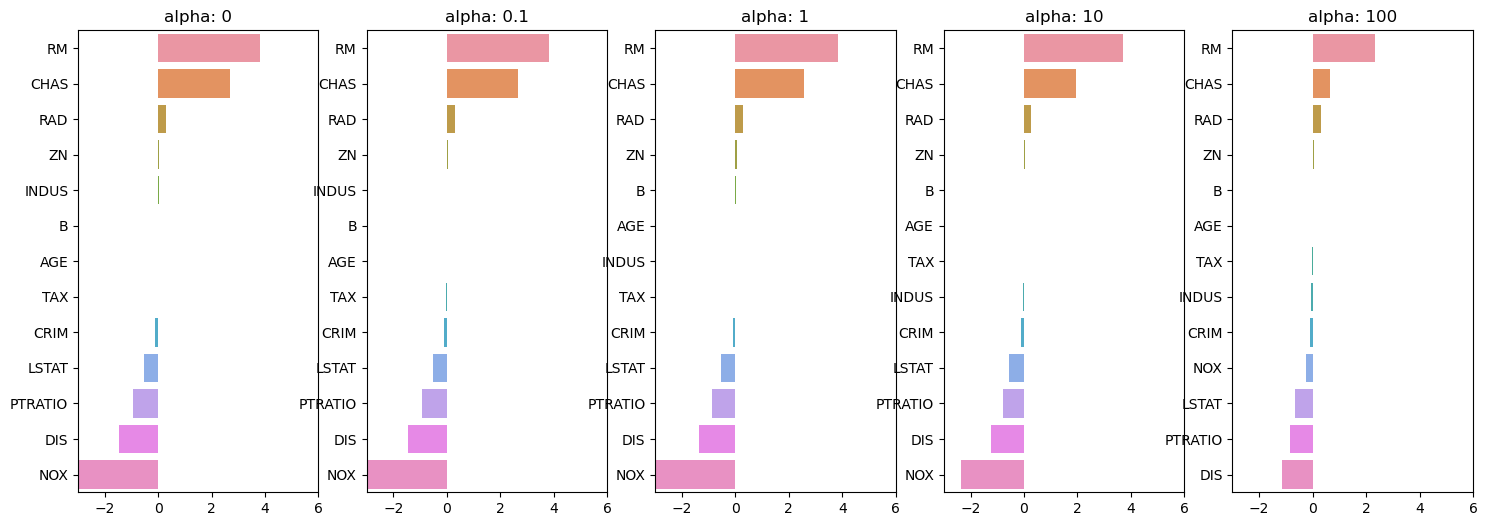

In [40]:
alphas = [0, 0.1, 1, 10, 100]
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)

coeff_df = pd.DataFrame() #각 alpha값에 따른 회귀 계수 값을 df로 저장하기 위한 빈 df

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    # 피처별 회귀계수를 series로 변환하고 df의 컬럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha: '+ str(alpha)
    coeff_df[colname] = coeff
    # 시각화
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
coeff_df

## 결과
- alpha값이 커질수록 가장 많은 영향을 미치는 RM특성의 가중치도 같이  작아짐
- 다른 특성에 비해 회귀계수가 이상치로 컸던 NOX는 가장 크게 줄어듦
- 예측성능이 좋아짐
    - 그 이유는 NOX의 회귀 계수값을 적절한 수준으로 맞춰서 모델이 조금 더 일반화되었다는 것을 알 수 있음